In [2]:
###PRE-PROCESSING

import pandas as pd
import numpy as np
import re
import spacy
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from textblob import TextBlob
from transformers import BertTokenizer
from collections import Counter

# Load Spacy Model for NER
nlp = spacy.load("en_core_web_sm")

# Load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    words = text.split()
    words = [word for word in words if word not in ENGLISH_STOP_WORDS]  # Remove stopwords
    return ' '.join(words)

def extract_named_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity  # Returns a score between -1 and 1

# Load dataset with proper dtypes to prevent scientific notation
df = pd.read_csv("/content/caphill.csv", dtype={"id": str, "reply_to_id": str, "conversation_id": str})

# Standardize column names
df.columns = df.columns.str.lower().str.replace(" ", "_")

# Drop duplicates
df.drop_duplicates(inplace=True)

# Remove rows only if 'text' column is empty
df = df[df['text'].notna() & (df['text'].str.strip() != '')]

# Apply text preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)
df['named_entities'] = df['text'].apply(extract_named_entities)
df['sentiment'] = df['text'].apply(get_sentiment)

# Replace empty reply_to_nm with "None"
df["reply_to_nm"] = df["reply_to_nm"].fillna("None").astype(str)
df.loc[df["reply_to_nm"].str.strip() == "", "reply_to_nm"] = "None"

# Convert timestamp format to 'YYYY-MM-DD HH:MM:SS'
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce').dt.strftime('%Y-%m-%d %H:%M:%S')

# Tokenization using BERT
df['tokens'] = df['cleaned_text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

# Drop the reply_to_id column
df.drop(columns=['reply_to_id'], inplace=True)

# Save processed data
df.to_csv("cap_processed_tweets.csv", index=False)

print("✅ Processing complete. Data saved as 'cap_processed_tweets.csv'")


✅ Processing complete. Data saved as 'cap_processed_tweets.csv'


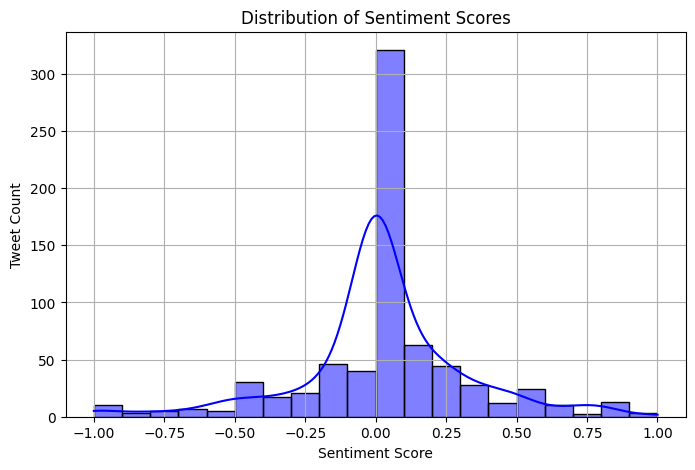

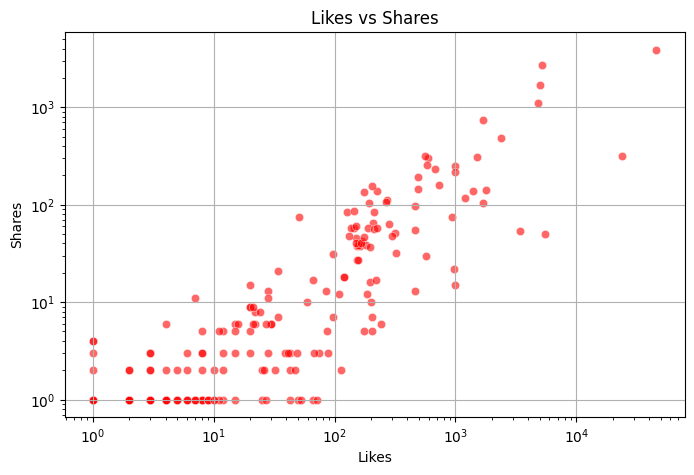

<ipython-input-3-f7593189b3dc>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(entities), palette="coolwarm")


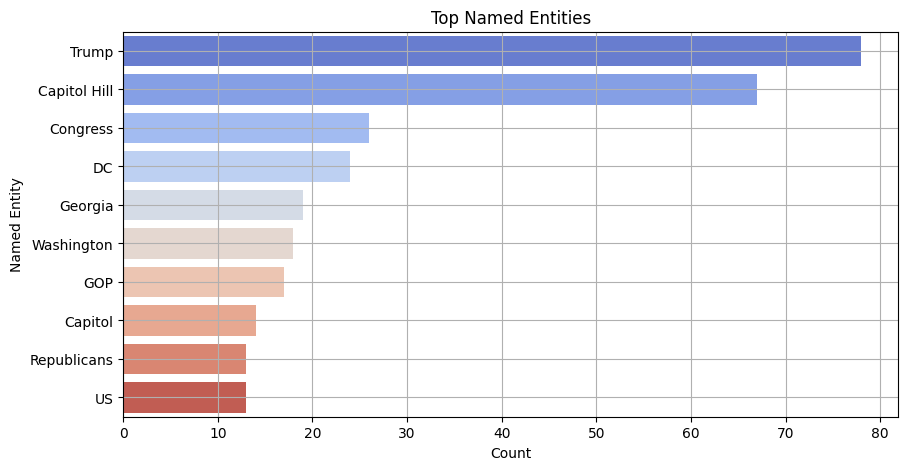

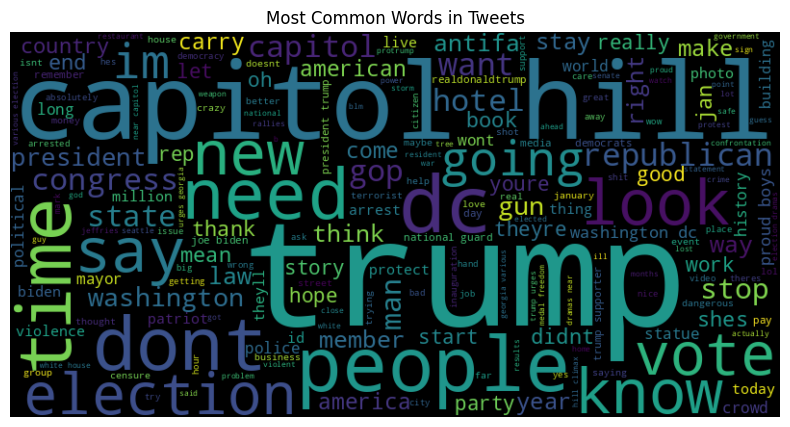

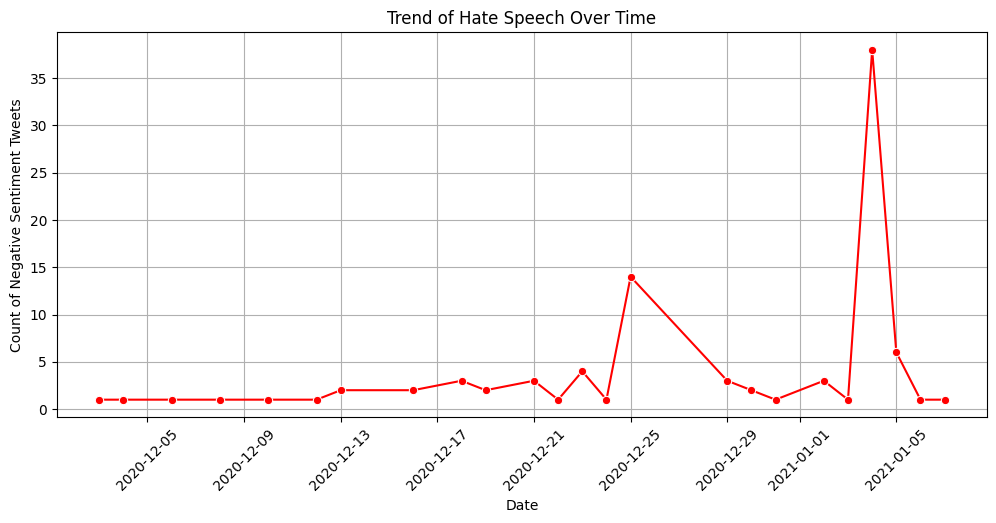

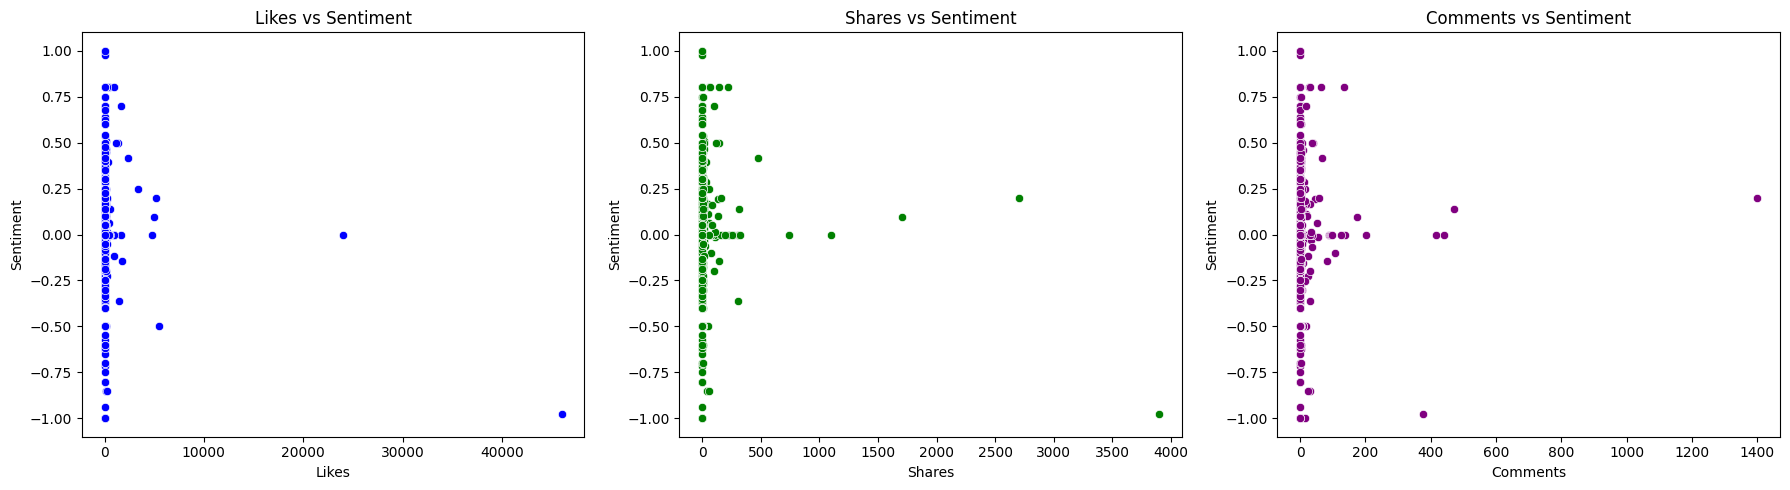

In [3]:
###VISUALISING-

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import ast  # To convert string representations of lists back to lists

# Load dataset
df = pd.read_csv("cap_processed_tweets.csv")

# Convert timestamp to proper datetime format
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# Convert named_entities from string to list of tuples (if needed)
df["named_entities"] = df["named_entities"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# 1️⃣ Sentiment Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["sentiment"], bins=20, kde=True, color="blue")
plt.xlabel("Sentiment Score")
plt.ylabel("Tweet Count")
plt.title("Distribution of Sentiment Scores")
plt.grid()
plt.show()

# 2️⃣ Scatter Plot of Likes vs Shares (Ensure no NaN values)
df_filtered = df.dropna(subset=["likes", "shares"])
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_filtered["likes"], y=df_filtered["shares"], alpha=0.6, color="red")
plt.xlabel("Likes")
plt.ylabel("Shares")
plt.title("Likes vs Shares")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.show()

# 3️⃣ Most Common Named Entities
all_entities = [entity[0] for sublist in df["named_entities"] for entity in sublist]  # Extract entity names
entity_counts = Counter(all_entities).most_common(10)  # Get top 10 entities
entities, counts = zip(*entity_counts) if entity_counts else ([], [])

plt.figure(figsize=(10, 5))
sns.barplot(x=list(counts), y=list(entities), palette="coolwarm")
plt.xlabel("Count")
plt.ylabel("Named Entity")
plt.title("Top Named Entities")
plt.grid()
plt.show()

# 4️⃣ Word Cloud of Cleaned Text
text = " ".join(df["cleaned_text"].dropna())  # Combine all cleaned text
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Tweets")
plt.show()

# 5️⃣ Trend of Negative Sentiment Over Time
df['date'] = df['timestamp'].dt.date  # Extract only date
time_series = df[df['sentiment'] < -0.2].groupby('date').size()

plt.figure(figsize=(12, 5))
sns.lineplot(x=time_series.index, y=time_series.values, marker='o', color='red')
plt.xlabel("Date")
plt.ylabel("Count of Negative Sentiment Tweets")
plt.title("Trend of Hate Speech Over Time")
plt.xticks(rotation=45)
plt.grid()
plt.show()

# 6️⃣ Most Engaged Tweets - Sentiment vs Engagement
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Likes vs Sentiment
sns.scatterplot(ax=axes[0], x=df_filtered['likes'], y=df_filtered['sentiment'], color='blue')
axes[0].set_title("Likes vs Sentiment")
axes[0].set_xlabel("Likes")
axes[0].set_ylabel("Sentiment")

# Shares vs Sentiment
sns.scatterplot(ax=axes[1], x=df_filtered['shares'], y=df_filtered['sentiment'], color='green')
axes[1].set_title("Shares vs Sentiment")
axes[1].set_xlabel("Shares")
axes[1].set_ylabel("Sentiment")

# Comments vs Sentiment
sns.scatterplot(ax=axes[2], x=df_filtered['num_comments'], y=df_filtered['sentiment'], color='purple')
axes[2].set_title("Comments vs Sentiment")
axes[2].set_xlabel("Comments")
axes[2].set_ylabel("Sentiment")

plt.tight_layout()
plt.show()


# CONCLUSIONS

**Img1:** Sentiment Distribution – Most tweets are neutral (0.0), with fewer being highly positive or negative.

**Img2:** Likes vs Shares – A positive correlation exists; tweets with more likes tend to get more shares, but the spread varies.

**Img3:** Top 10 Named Entities – Displays the most frequently mentioned entities in the dataset.

**Img4:** Named Entity Word Cloud – A visual representation of the most common named entities.

**Img5** Hate Speech Trend – A spike in negative sentiment tweets appears in early January 2021, suggesting a peak in hate speech.

**Img6:** Likes vs Sentiment – Most tweets, regardless of sentiment, receive low engagement (likes).

**Img7:** Shares vs Sentiment – Negative and neutral tweets are commonly shared, but extreme sentiments sometimes gain high shares.

**Img8:** Comments vs Sentiment – Tweets with both high negative and high positive sentiment get some engagement, but most receive few comments.

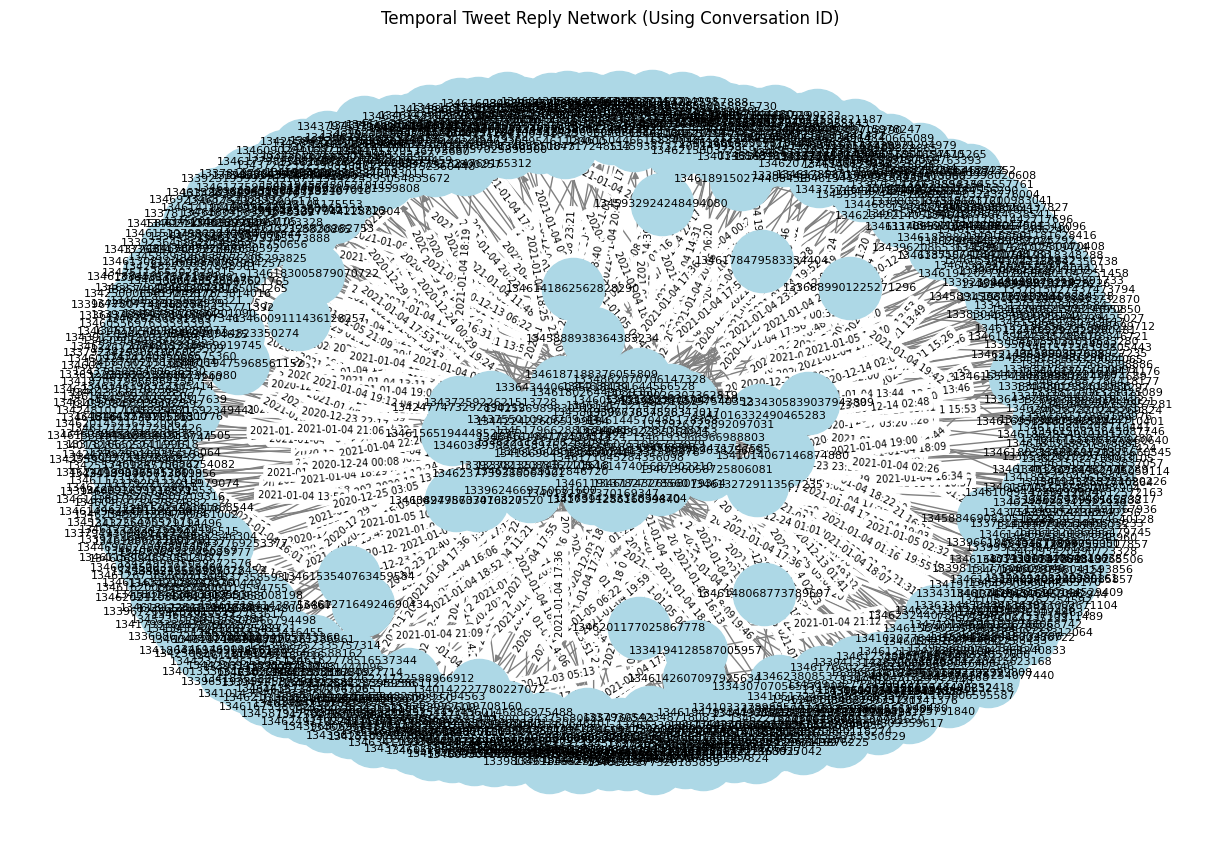

In [5]:
###CONSTRUCT THE TGN-

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("cap_processed_tweets.csv")

# Convert timestamp to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create a directed graph
G = nx.DiGraph()

# Add nodes (each tweet is a node)
for _, row in df.iterrows():
    G.add_node(row['id'],
               speaker=row.get('speaker_nm', 'Unknown'),
               text=row.get('text', ''),
               timestamp=row['timestamp'])

# Add edges using conversation_id instead of reply_to_id
for _, row in df.iterrows():
    if row['conversation_id'] != row['id']:  # Ensure it's a reply (not the original tweet)
        if row['conversation_id'] not in G:  # Handle missing parent tweets
            G.add_node(row['conversation_id'], speaker="Unknown", text="", timestamp=None)

        G.add_edge(row['conversation_id'], row['id'], relation="reply", timestamp=row['timestamp'])

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Layout for visualization

# Draw nodes
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=8)

# Draw edge labels (timestamps)
edge_labels = {(u, v): d['timestamp'].strftime('%Y-%m-%d %H:%M') if d['timestamp'] else "Unknown"
               for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

plt.title("Temporal Tweet Reply Network (Using Conversation ID)")
plt.show()


In [6]:
###PRINT THE NODES AND EDGES-

import networkx as nx
import pandas as pd

# Load dataset
df = pd.read_csv("cap_processed_tweets.csv")

# Convert timestamp to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create a directed graph
G = nx.DiGraph()

# Add nodes (each tweet is a node)
for _, row in df.iterrows():
    G.add_node(row['id'],
               speaker=row.get('speaker_nm', 'Unknown'),
               text=row.get('text', ''),
               timestamp=row['timestamp'])

# Add edges using conversation_id instead of reply_to_id
for _, row in df.iterrows():
    if row['conversation_id'] != row['id']:  # Ensure it's a reply (not the original tweet)
        if row['conversation_id'] not in G:  # Handle missing parent tweets
            G.add_node(row['conversation_id'], speaker="Unknown", text="", timestamp=None)

        G.add_edge(row['conversation_id'], row['id'], relation="reply", timestamp=row['timestamp'])

# Print Nodes
print("Nodes:")
for node, data in G.nodes(data=True):
    print(node, data)

# Print Edges
print("\nEdges:")
for u, v, data in G.edges(data=True):
    print(f"{u} -> {v}, {data}")

Nodes:
1339230232088367105 {'speaker': 'MrAndyNgo', 'text': 'BLM-antifa in Seattle have set up another autonomous zone at Cal Anderson Park in the Capital Hill neighborhood. This is the same area they made CHAZ during the summer months. Video by \n@choeshow\n:', 'timestamp': Timestamp('2020-12-16 15:25:43')}
1339230948488073219 {'speaker': 'Freakoutery', 'text': 'At some point it seems as if we could just start tweeting out videos of landfills and Haitian ghettos and say "another autonomous zone has erupted in ___" and they\'d be totally believable.', 'timestamp': Timestamp('2020-12-16 15:28:34')}
1339451172659322882 {'speaker': 'DevinCow', 'text': 'Hay \n@KathrynTewson\n they’re lying again', 'timestamp': Timestamp('2020-12-17 06:03:40')}
1339236439620349957 {'speaker': 'palindromemood', 'text': 'This is what we have to look forward to in the Harris/Biden administration. By the time the sympathizers wake up, it’ll be too late.', 'timestamp': Timestamp('2020-12-16 15:50:23')}
133923153